<a href="https://colab.research.google.com/github/levvathecoder/The-FitSphere-APP/blob/main/FitSphere_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏋️ FitSphere AI - Complete ML Pipeline

This notebook implements a comprehensive ML pipeline for personalized workout generation with explainability features for the Final Year Project.

**Novelty Features:**
- SHAP Explainability ("Why this workout?")
- Multi-Task Learning (5 outputs from 1 model)
- Recovery-Aware Training (HRV, sleep, recovery)

**Pipeline Steps:**
1. Setup & Kaggle Authentication
2. Data Acquisition
3. Data Cleaning
4. Feature Engineering (45 features)
5. Train/Val/Test Split
6. Model Architecture
7. Training
8. Evaluation
9. SHAP Explainability
10. Model Export

## 1️⃣ Setup & Install Dependencies

In [2]:
# Install required packages
!pip install -q kaggle tensorflow scikit-learn pandas numpy matplotlib seaborn shap

In [3]:
# Import libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# Explainability
import shap

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2️⃣ Kaggle Authentication (Optional)

If you want to download real Kaggle datasets, upload your `kaggle.json` file.

In [4]:
# OPTIONAL: Upload kaggle.json for real datasets
# Uncomment the lines below if you want to use Kaggle datasets

# from google.colab import files
# uploaded = files.upload()  # Upload kaggle.json

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download datasets
# !kaggle datasets download -d valakhorasani/gym-members-exercise-dataset -p ./data --unzip

print("Using synthetic data for demo (Kaggle optional)")

Using synthetic data for demo (Kaggle optional)


## 3️⃣ Data Generation (Synthetic Data)

Generating 3000+ samples simulating real fitness user data.

In [5]:
def generate_synthetic_fitness_data(n_samples=3000):
    """
    Generate synthetic fitness data matching Kaggle datasets structure.
    """
    np.random.seed(42)

    # Demographics
    ages = np.random.normal(35, 12, n_samples).clip(18, 65).astype(int)
    genders = np.random.choice(['Male', 'Female'], n_samples, p=[0.55, 0.45])
    weights = np.where(
        genders == 'Male',
        np.random.normal(80, 15, n_samples),
        np.random.normal(65, 12, n_samples)
    ).clip(45, 150)
    heights = np.where(
        genders == 'Male',
        np.random.normal(175, 8, n_samples),
        np.random.normal(163, 7, n_samples)
    ).clip(145, 200)

    # Calculate BMI
    bmi = weights / ((heights/100) ** 2)

    # Fitness profiles
    fitness_levels = np.random.choice(
        ['beginner', 'intermediate', 'advanced'],
        n_samples,
        p=[0.4, 0.45, 0.15]
    )

    goals = np.random.choice(
        ['muscle_gain', 'fat_loss', 'strength', 'endurance'],
        n_samples,
        p=[0.35, 0.3, 0.2, 0.15]
    )

    equipment_options = ['full_gym', 'home_gym', 'minimal', 'bodyweight']
    equipment = [
        np.random.choice(equipment_options,
                        size=np.random.randint(1, 4),
                        replace=False).tolist()
        for _ in range(n_samples)
    ]

    # Biometrics (recovery-aware features)
    resting_hr = np.random.normal(65, 10, n_samples).clip(45, 90)
    max_hr = 220 - ages + np.random.normal(0, 5, n_samples)
    avg_hr = (max_hr + resting_hr) / 2 + np.random.normal(0, 10, n_samples)

    # HRV - Higher is better (50-100ms typical range)
    hrv = np.random.normal(60, 15, n_samples).clip(20, 100)

    # Sleep hours
    sleep_hours = np.random.normal(7, 1.5, n_samples).clip(4, 10)

    # Recovery score (0-100, influenced by sleep and HRV)
    recovery_score = (
        0.4 * (hrv / 100 * 100) +
        0.3 * (sleep_hours / 10 * 100) +
        0.3 * np.random.uniform(0.6, 1.0, n_samples) * 100
    ).clip(20, 100)

    # Historical workout data
    session_duration = np.random.normal(60, 20, n_samples).clip(20, 120)
    workouts_per_week = np.random.choice([1, 2, 3, 4, 5, 6], n_samples,
                                          p=[0.1, 0.15, 0.25, 0.25, 0.15, 0.1])

    # Calories burned
    calories_burned = (
        session_duration *
        (weights / 70) *
        np.random.uniform(5, 12, n_samples)
    ).astype(int)

    # Focus areas
    muscle_groups = ['chest', 'back', 'legs', 'shoulders', 'arms', 'core']
    focus_areas = [
        np.random.choice(muscle_groups,
                        size=np.random.randint(1, 4),
                        replace=False).tolist()
        for _ in range(n_samples)
    ]

    # TARGET VARIABLES
    level_factor = np.where(fitness_levels == 'beginner', 0,
                           np.where(fitness_levels == 'intermediate', 1, 2))

    target_sets = (3 + level_factor * 0.5 +
                   np.where(goals == 'strength', 1, 0) +
                   np.random.normal(0, 0.5, n_samples)).clip(2, 6).astype(int)

    goal_reps = {
        'muscle_gain': 10, 'fat_loss': 15,
        'strength': 5, 'endurance': 18
    }
    target_reps = np.array([goal_reps[g] for g in goals]) + np.random.normal(0, 2, n_samples)
    target_reps = target_reps.clip(4, 20).astype(int)

    target_intensity = (
        0.7 +
        level_factor * 0.08 +
        (recovery_score / 100 - 0.7) * 0.3 +
        np.random.normal(0, 0.05, n_samples)
    ).clip(0.5, 1.0)

    goal_rest = {
        'muscle_gain': 90, 'fat_loss': 45,
        'strength': 180, 'endurance': 30
    }
    target_rest = np.array([goal_rest[g] for g in goals])
    target_rest = (target_rest + (target_intensity - 0.7) * 100 +
                   np.random.normal(0, 15, n_samples)).clip(30, 300).astype(int)

    workout_types = ['Strength', 'Cardio', 'HIIT', 'Yoga']
    goal_to_type = {
        'muscle_gain': 'Strength',
        'strength': 'Strength',
        'fat_loss': 'HIIT',
        'endurance': 'Cardio'
    }
    target_workout_type = [goal_to_type.get(g, 'Strength') for g in goals]
    for i in range(n_samples):
        if np.random.random() < 0.1:
            target_workout_type[i] = np.random.choice(workout_types)

    # Create DataFrame
    df = pd.DataFrame({
        'age': ages,
        'gender': genders,
        'weight_kg': weights.round(1),
        'height_cm': heights.round(1),
        'bmi': bmi.round(2),
        'fitness_level': fitness_levels,
        'goal': goals,
        'equipment': [','.join(e) for e in equipment],
        'resting_hr': resting_hr.astype(int),
        'max_hr': max_hr.astype(int),
        'avg_hr': avg_hr.astype(int),
        'hrv': hrv.round(1),
        'sleep_hours': sleep_hours.round(1),
        'recovery_score': recovery_score.round(1),
        'session_duration': session_duration.astype(int),
        'workouts_per_week': workouts_per_week,
        'calories_burned': calories_burned,
        'focus_areas': [','.join(f) for f in focus_areas],
        'target_sets': target_sets,
        'target_reps': target_reps,
        'target_intensity': target_intensity.round(3),
        'target_rest_seconds': target_rest,
        'target_workout_type': target_workout_type
    })

    return df

In [6]:
# Generate data
print("📊 Generating synthetic fitness data...")
raw_data = generate_synthetic_fitness_data(n_samples=3000)
print(f"✅ Generated {len(raw_data)} samples")
print(f"\n📋 Dataset shape: {raw_data.shape}")
print(f"\n📋 Columns: {list(raw_data.columns)}")
raw_data.head()

📊 Generating synthetic fitness data...
✅ Generated 3000 samples

📋 Dataset shape: (3000, 23)

📋 Columns: ['age', 'gender', 'weight_kg', 'height_cm', 'bmi', 'fitness_level', 'goal', 'equipment', 'resting_hr', 'max_hr', 'avg_hr', 'hrv', 'sleep_hours', 'recovery_score', 'session_duration', 'workouts_per_week', 'calories_burned', 'focus_areas', 'target_sets', 'target_reps', 'target_intensity', 'target_rest_seconds', 'target_workout_type']


,age,gender,weight_kg,height_cm,bmi,fitness_level,goal,equipment,resting_hr,max_hr,...,recovery_score,session_duration,workouts_per_week,calories_burned,focus_areas,target_sets,target_reps,target_intensity,target_rest_seconds,target_workout_type
0,40,Female,75.5,154.1,31.80,advanced,endurance,"home_gym,full_gym,bodyweight",62,188,...,76.6,20,5,139,"core,shoulders,arms",3,19,0.774,42,Cardio
1,33,Female,69.2,171.4,23.57,beginner,fat_loss,"full_gym,bodyweight,minimal",49,185,...,72.8,50,4,559,legs,3,13,0.702,45,HIIT
2,42,Male,100.4,171.4,34.20,beginner,muscle_gain,bodyweight,47,171,...,85.1,58,4,965,chest,3,11,0.820,90,Strength
3,53,Female,69.6,160.6,26.97,advanced,muscle_gain,"bodyweight,home_gym",69,172,...,71.1,30,2,307,"back,core",4,8,0.850,84,Strength
4,32,Male,72.7,164.7,26.79,beginner,endurance,"full_gym,minimal",53,186,...,75.3,57,6,549,"shoulders,chest,core",2,20,0.670,30,Cardio


## 4️⃣ Data Cleaning

In [7]:
def clean_fitness_data(df):
    """Clean and preprocess the fitness dataset."""
    print("🧹 Starting data cleaning...")

    df_clean = df.copy()
    original_rows = len(df_clean)

    # Handle missing values
    print(f"   Missing values before: {df_clean.isnull().sum().sum()}")
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

    print(f"   Missing values after: {df_clean.isnull().sum().sum()}")

    # Remove duplicates
    duplicates = df_clean.duplicated().sum()
    df_clean = df_clean.drop_duplicates()
    print(f"   Removed {duplicates} duplicate rows")

    # Handle outliers using IQR
    outlier_cols = ['weight_kg', 'height_cm', 'bmi', 'hrv', 'recovery_score']
    total_outliers = 0

    for col in outlier_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
            total_outliers += outliers
            df_clean[col] = df_clean[col].clip(lower, upper)

    print(f"   Capped {total_outliers} outlier values")
    print(f"✅ Data cleaning complete: {original_rows} → {len(df_clean)} rows")

    return df_clean

# Clean the data
cleaned_data = clean_fitness_data(raw_data)
cleaned_data.describe()

🧹 Starting data cleaning...
   Missing values before: 0
   Missing values after: 0
   Removed 0 duplicate rows
   Capped 65 outlier values
✅ Data cleaning complete: 3000 → 3000 rows


,age,weight_kg,height_cm,bmi,resting_hr,max_hr,avg_hr,hrv,sleep_hours,recovery_score,session_duration,workouts_per_week,calories_burned,target_sets,target_reps,target_intensity,target_rest_seconds
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,35.256667,73.243750,169.794267,25.467930,64.425333,184.193667,124.389333,60.087133,6.998767,69.163333,59.662000,3.521667,539.285667,3.121333,11.225333,0.759108,93.126333
std,10.999536,15.375323,9.602937,5.242651,9.920512,11.974248,12.642271,15.238716,1.431504,8.319218,19.411097,1.436042,257.835316,0.770807,4.600320,0.078849,54.450136
min,18.000000,45.000000,145.000000,11.650000,45.000000,143.000000,83.000000,20.000000,4.000000,45.700000,20.000000,1.000000,90.000000,2.000000,4.000000,0.506000,30.000000
25%,27.000000,62.100000,163.000000,21.680000,58.000000,176.000000,116.000000,50.175000,6.000000,63.400000,46.000000,3.000000,348.000000,3.000000,7.000000,0.703000,49.000000
50%,35.000000,71.800000,169.650000,25.245000,64.000000,184.000000,124.000000,59.900000,7.000000,69.300000,60.000000,3.000000,494.000000,3.000000,11.000000,0.757000,81.000000
75%,43.000000,83.000000,176.500000,28.880000,71.000000,193.000000,133.000000,70.425000,8.000000,75.200000,73.000000,5.000000,689.000000,4.000000,15.000000,0.813000,115.000000
max,65.000000,114.350000,196.750000,39.680000,90.000000,216.000000,167.000000,100.000000,10.000000,92.500000,120.000000,6.000000,2068.000000,6.000000,20.000000,1.000000,233.000000


## 5️⃣ Feature Engineering (45 Features)

In [8]:
def engineer_features(df):
    """
    Create 45+ engineered features for ML model.
    """
    print("⚙️ Starting feature engineering...")

    df_feat = df.copy()

    # Gender encoding
    df_feat['gender_encoded'] = (df_feat['gender'] == 'Male').astype(int)

    # Fitness level encoding
    level_map = {'beginner': 0, 'intermediate': 1, 'advanced': 2}
    df_feat['fitness_level_encoded'] = df_feat['fitness_level'].map(level_map)

    # Goal one-hot encoding
    goals = ['muscle_gain', 'fat_loss', 'strength', 'endurance']
    for goal in goals:
        df_feat[f'goal_{goal}'] = (df_feat['goal'] == goal).astype(int)

    # Equipment one-hot
    equipment_types = ['full_gym', 'home_gym', 'minimal', 'bodyweight']
    for equip in equipment_types:
        df_feat[f'has_{equip}'] = df_feat['equipment'].str.contains(equip).astype(int)

    # Focus areas one-hot
    muscle_groups = ['chest', 'back', 'legs', 'shoulders', 'arms', 'core']
    for muscle in muscle_groups:
        df_feat[f'focus_{muscle}'] = df_feat['focus_areas'].str.contains(muscle).astype(int)

    # BMI categories
    df_feat['bmi_underweight'] = (df_feat['bmi'] < 18.5).astype(int)
    df_feat['bmi_normal'] = ((df_feat['bmi'] >= 18.5) & (df_feat['bmi'] < 25)).astype(int)
    df_feat['bmi_overweight'] = ((df_feat['bmi'] >= 25) & (df_feat['bmi'] < 30)).astype(int)
    df_feat['bmi_obese'] = (df_feat['bmi'] >= 30).astype(int)

    # Age groups
    df_feat['age_group_young'] = (df_feat['age'] < 30).astype(int)
    df_feat['age_group_adult'] = ((df_feat['age'] >= 30) & (df_feat['age'] < 45)).astype(int)
    df_feat['age_group_middle'] = ((df_feat['age'] >= 45) & (df_feat['age'] < 60)).astype(int)
    df_feat['age_group_senior'] = (df_feat['age'] >= 60).astype(int)

    # Recovery metrics
    df_feat['recovery_normalized'] = df_feat['recovery_score'] / 100.0
    df_feat['hrv_normalized'] = df_feat['hrv'] / 100.0
    df_feat['sleep_score'] = (df_feat['sleep_hours'] / 8.0).clip(0, 1.5)

    # TRAINING READINESS - KEY NOVELTY FEATURE
    df_feat['training_readiness'] = (
        df_feat['recovery_normalized'] * 0.4 +
        df_feat['hrv_normalized'] * 0.3 +
        df_feat['sleep_score'] * 0.3
    )

    # Age-adjusted fitness
    df_feat['age_factor'] = 1.0 - (np.abs(df_feat['age'] - 30) / 100.0)
    df_feat['age_factor'] = df_feat['age_factor'].clip(0.5, 1.0)
    df_feat['fitness_score'] = df_feat['fitness_level_encoded'] * df_feat['age_factor']

    # Derived metrics
    df_feat['volume_capacity'] = df_feat['fitness_level_encoded'] * df_feat['recovery_normalized']
    df_feat['intensity_tolerance'] = df_feat['fitness_level_encoded'] * df_feat['training_readiness']
    df_feat['hr_reserve'] = df_feat['max_hr'] - df_feat['resting_hr']
    df_feat['frequency_score'] = df_feat['workouts_per_week'] / 6.0
    df_feat['session_intensity'] = (df_feat['calories_burned'] / df_feat['session_duration']).fillna(0)
    df_feat['equipment_count'] = df_feat['equipment'].str.count(',') + 1
    df_feat['focus_count'] = df_feat['focus_areas'].str.count(',') + 1
    df_feat['recovery_sleep_interaction'] = df_feat['recovery_score'] * df_feat['sleep_hours'] / 100
    df_feat['training_sophistication'] = df_feat['fitness_level_encoded'] * df_feat['equipment_count']
    df_feat['fatigue_indicator'] = 1 - df_feat['training_readiness']

    # Select features
    feature_columns = [
        'age', 'gender_encoded', 'weight_kg', 'height_cm', 'bmi',
        'fitness_level_encoded', 'fitness_score', 'age_factor',
        'goal_muscle_gain', 'goal_fat_loss', 'goal_strength', 'goal_endurance',
        'has_full_gym', 'has_home_gym', 'has_minimal', 'has_bodyweight',
        'focus_chest', 'focus_back', 'focus_legs', 'focus_shoulders', 'focus_arms', 'focus_core',
        'bmi_underweight', 'bmi_normal', 'bmi_overweight', 'bmi_obese',
        'age_group_young', 'age_group_adult', 'age_group_middle', 'age_group_senior',
        'recovery_score', 'recovery_normalized', 'hrv', 'hrv_normalized', 'sleep_hours', 'sleep_score',
        'resting_hr', 'avg_hr', 'hr_reserve',
        'training_readiness', 'volume_capacity', 'intensity_tolerance',
        'frequency_score', 'session_intensity', 'equipment_count',
        'focus_count', 'recovery_sleep_interaction', 'training_sophistication', 'fatigue_indicator'
    ]

    target_columns = ['target_sets', 'target_reps', 'target_intensity', 'target_rest_seconds', 'target_workout_type']

    print(f"✅ Engineered {len(feature_columns)} features")
    return df_feat, feature_columns, target_columns

# Apply feature engineering
engineered_data, feature_cols, target_cols = engineer_features(cleaned_data)
print(f"\n📊 Final feature count: {len(feature_cols)}")

⚙️ Starting feature engineering...
✅ Engineered 49 features

📊 Final feature count: 49


## 6️⃣ Train/Val/Test Split (80/10/10)

In [9]:
def prepare_data_splits(df, feature_cols, target_cols):
    """Prepare train/validation/test splits."""
    print("🔄 Preparing data splits...")

    X = df[feature_cols].values

    # Targets
    y_sets = df['target_sets'].values
    y_reps = df['target_reps'].values
    y_intensity = df['target_intensity'].values
    y_rest = df['target_rest_seconds'].values

    # Encode workout type
    le_workout = LabelEncoder()
    y_workout_type = le_workout.fit_transform(df['target_workout_type'])
    num_classes = len(le_workout.classes_)
    print(f"   Workout type classes: {le_workout.classes_}")

    # Split
    X_train, X_temp, y_sets_train, y_sets_temp = train_test_split(X, y_sets, test_size=0.2, random_state=42)
    X_val, X_test, y_sets_val, y_sets_test = train_test_split(X_temp, y_sets_temp, test_size=0.5, random_state=42)

    # Same splits for other targets
    _, _, y_reps_train, y_reps_temp = train_test_split(X, y_reps, test_size=0.2, random_state=42)
    _, _, y_reps_val, y_reps_test = train_test_split(X_temp, y_reps_temp, test_size=0.5, random_state=42)

    _, _, y_intensity_train, y_intensity_temp = train_test_split(X, y_intensity, test_size=0.2, random_state=42)
    _, _, y_intensity_val, y_intensity_test = train_test_split(X_temp, y_intensity_temp, test_size=0.5, random_state=42)

    _, _, y_rest_train, y_rest_temp = train_test_split(X, y_rest, test_size=0.2, random_state=42)
    _, _, y_rest_val, y_rest_test = train_test_split(X_temp, y_rest_temp, test_size=0.5, random_state=42)

    _, _, y_type_train, y_type_temp = train_test_split(X, y_workout_type, test_size=0.2, random_state=42)
    _, _, y_type_val, y_type_test = train_test_split(X_temp, y_type_temp, test_size=0.5, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"✅ Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    return {
        'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
        'X_train_unscaled': X_train,
        'y_train': {'sets': y_sets_train, 'reps': y_reps_train, 'intensity': y_intensity_train, 'rest': y_rest_train, 'workout_type': y_type_train},
        'y_val': {'sets': y_sets_val, 'reps': y_reps_val, 'intensity': y_intensity_val, 'rest': y_rest_val, 'workout_type': y_type_val},
        'y_test': {'sets': y_sets_test, 'reps': y_reps_test, 'intensity': y_intensity_test, 'rest': y_rest_test, 'workout_type': y_type_test},
        'scaler': scaler, 'label_encoder': le_workout, 'num_classes': num_classes, 'feature_names': feature_cols
    }

data = prepare_data_splits(engineered_data, feature_cols, target_cols)

🔄 Preparing data splits...
   Workout type classes: ['Cardio' 'HIIT' 'Strength' np.str_('Yoga')]
✅ Train: 2400 | Val: 300 | Test: 300


## 7️⃣ Model Architecture (Multi-Output NN)

In [10]:
def create_multi_output_model(input_dim, num_workout_classes):
    """
    Multi-output neural network for workout prediction.
    5 Outputs: Sets, Reps, Intensity, Rest, Workout Type
    """
    inputs = layers.Input(shape=(input_dim,), name='input_features')

    # Shared backbone
    x = layers.Dense(256, activation='relu', name='shared_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu', name='shared_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu', name='shared_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    shared_features = layers.Dense(32, activation='relu', name='shared_features')(x)

    # Output heads
    sets_output = layers.Dense(16, activation='relu')(shared_features)
    sets_output = layers.Dense(1, activation='linear', name='output_sets')(sets_output)

    reps_output = layers.Dense(16, activation='relu')(shared_features)
    reps_output = layers.Dense(1, activation='linear', name='output_reps')(reps_output)

    intensity_output = layers.Dense(16, activation='relu')(shared_features)
    intensity_output = layers.Dense(1, activation='sigmoid', name='output_intensity')(intensity_output)

    rest_output = layers.Dense(16, activation='relu')(shared_features)
    rest_output = layers.Dense(1, activation='linear', name='output_rest')(rest_output)

    type_output = layers.Dense(32, activation='relu')(shared_features)
    type_output = layers.Dense(16, activation='relu')(type_output)
    type_output = layers.Dense(num_workout_classes, activation='softmax', name='output_type')(type_output)

    model = Model(
        inputs=inputs,
        outputs=[sets_output, reps_output, intensity_output, rest_output, type_output],
        name='FitSphere_MultiOutput_Model'
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'output_sets': 'mse', 'output_reps': 'mse',
            'output_intensity': 'mse', 'output_rest': 'mse',
            'output_type': 'sparse_categorical_crossentropy'
        },
        loss_weights={'output_sets': 1.0, 'output_reps': 1.0, 'output_intensity': 2.0, 'output_rest': 0.01, 'output_type': 1.0},
        metrics={
            'output_sets': ['mae'], 'output_reps': ['mae'],
            'output_intensity': ['mae'], 'output_rest': ['mae'],
            'output_type': ['accuracy']
        }
    )

    return model

model = create_multi_output_model(len(feature_cols), data['num_classes'])
model.summary()

Model: "FitSphere_MultiOutput_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 49)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_1 (Dense)    │ (None, 256)       │     12,800 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ shared_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_2 (Dense)    │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ shared_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_3 (Dense)    │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ shared_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_features     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ shared_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ shared_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ shared_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ shared_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ shared_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_sets (Dense) │ (None, 1)         │         17 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_reps (Dense) │ (None, 1)         │         17 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_intensity    │ (None, 1)         │         17 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_rest (Dense) │ (None, 1)         │         17 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_type (Dense) │ (None, 4)         │         68 │ dense_5[0][0]   

 Total params: 61,656 (240.84 KB)

 Trainable params: 60,760 (237.34 KB)

 Non-trainable params: 896 (3.50 KB)

## 8️⃣ Training

In [11]:
# Callbacks
training_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Prepare targets
y_train_dict = {
    'output_sets': data['y_train']['sets'],
    'output_reps': data['y_train']['reps'],
    'output_intensity': data['y_train']['intensity'],
    'output_rest': data['y_train']['rest'],
    'output_type': data['y_train']['workout_type']
}

y_val_dict = {
    'output_sets': data['y_val']['sets'],
    'output_reps': data['y_val']['reps'],
    'output_intensity': data['y_val']['intensity'],
    'output_rest': data['y_val']['rest'],
    'output_type': data['y_val']['workout_type']
}

# Train!
print("🏋️ Starting training...")
history = model.fit(
    data['X_train'],
    y_train_dict,
    validation_data=(data['X_val'], y_val_dict),
    epochs=100,
    batch_size=32,
    callbacks=training_callbacks,
    verbose=1
)
print("✅ Training complete!")

🏋️ Starting training...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 242.2136 - output_intensity_loss: 0.1073 - output_intensity_mae: 0.2746 - output_reps_loss: 123.7358 - output_reps_mae: 10.1116 - output_rest_loss: 10653.4258 - output_rest_mae: 88.2925 - output_sets_loss: 10.4461 - output_sets_mae: 2.9260 - output_type_accuracy: 0.4100 - output_type_loss: 1.2828 - val_loss: 174.9224 - val_output_intensity_loss: 0.0160 - val_output_intensity_mae: 0.1029 - val_output_reps_loss: 56.1667 - val_output_reps_mae: 6.6588 - val_output_rest_loss: 11344.1211 - val_output_rest_mae: 90.5473 - val_output_sets_loss: 3.2178 - val_output_sets_mae: 1.5513 - val_output_type_accuracy: 0.6533 - val_output_type_loss: 1.0549 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 102.7202 - output_intensity_loss: 0.0202 - output_intensity_mae: 0.1170 - output_reps_loss: 13.6187 - output_reps_mae: 2.9340 - output_rest_loss: 8603.6426 - output_rest_mae: 72.9411 - o

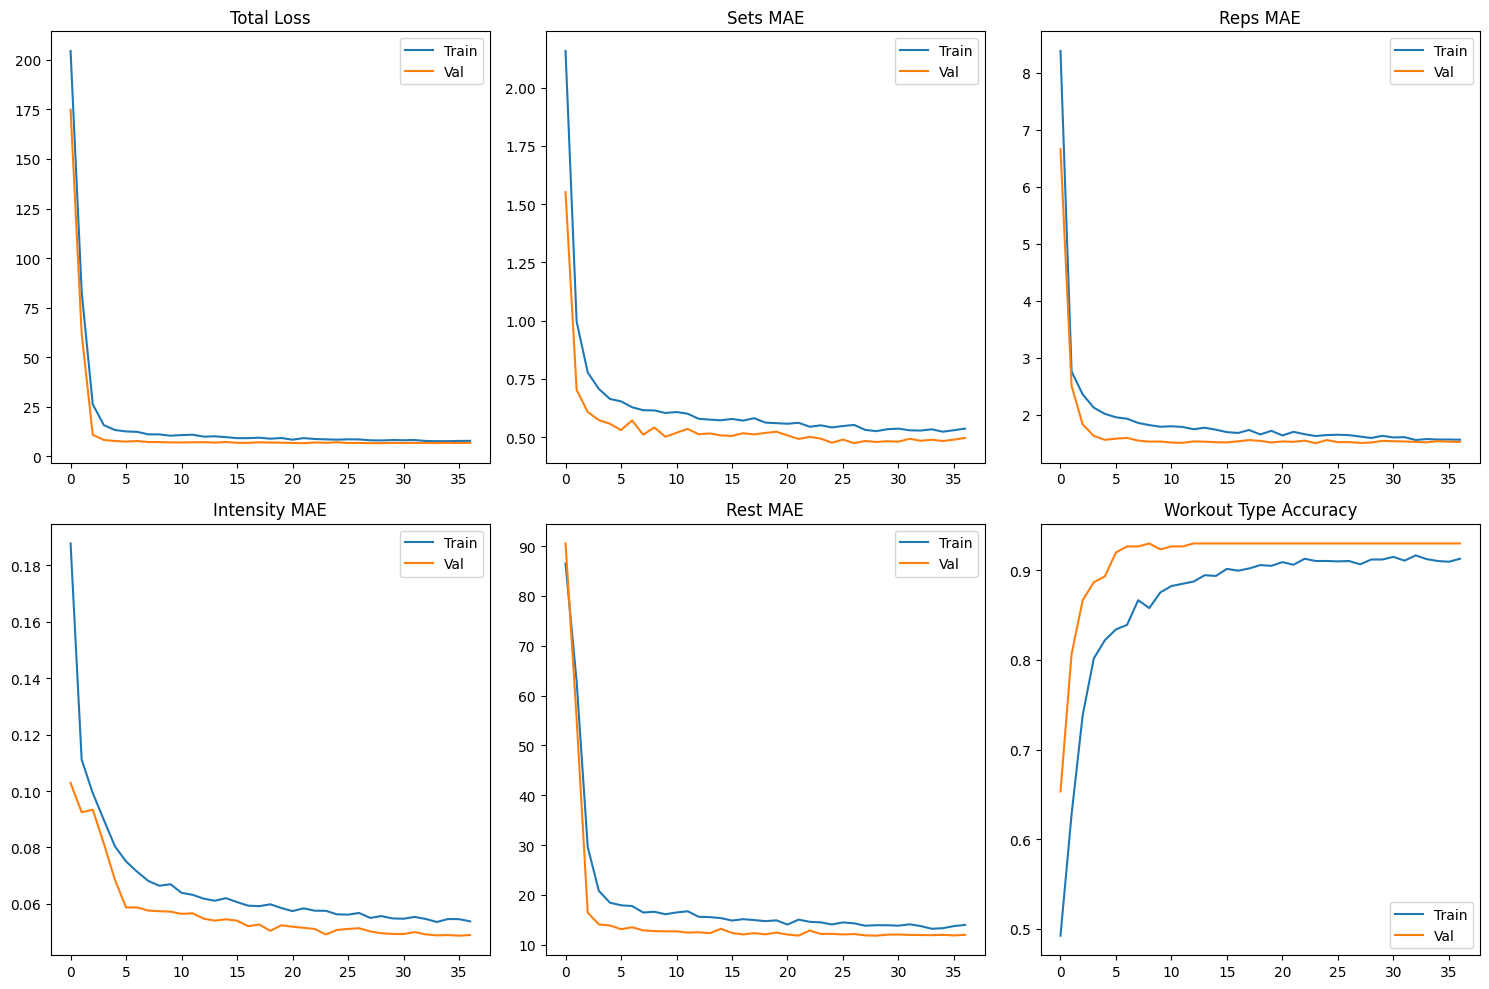

In [12]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Val')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()

axes[0, 1].plot(history.history['output_sets_mae'], label='Train')
axes[0, 1].plot(history.history['val_output_sets_mae'], label='Val')
axes[0, 1].set_title('Sets MAE')
axes[0, 1].legend()

axes[0, 2].plot(history.history['output_reps_mae'], label='Train')
axes[0, 2].plot(history.history['val_output_reps_mae'], label='Val')
axes[0, 2].set_title('Reps MAE')
axes[0, 2].legend()

axes[1, 0].plot(history.history['output_intensity_mae'], label='Train')
axes[1, 0].plot(history.history['val_output_intensity_mae'], label='Val')
axes[1, 0].set_title('Intensity MAE')
axes[1, 0].legend()

axes[1, 1].plot(history.history['output_rest_mae'], label='Train')
axes[1, 1].plot(history.history['val_output_rest_mae'], label='Val')
axes[1, 1].set_title('Rest MAE')
axes[1, 1].legend()

axes[1, 2].plot(history.history['output_type_accuracy'], label='Train')
axes[1, 2].plot(history.history['val_output_type_accuracy'], label='Val')
axes[1, 2].set_title('Workout Type Accuracy')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

## 9️⃣ Evaluation

In [13]:
# Evaluate on test set
print("📊 Evaluating on test set...")

predictions = model.predict(data['X_test'])

pred_sets = predictions[0].flatten()
pred_reps = predictions[1].flatten()
pred_intensity = predictions[2].flatten()
pred_rest = predictions[3].flatten()
pred_type = np.argmax(predictions[4], axis=1)

print("\n" + "="*60)
print("📈 MODEL EVALUATION RESULTS")
print("="*60)

# Sets
print(f"\n🎯 SETS:")
print(f"   MSE: {mean_squared_error(data['y_test']['sets'], pred_sets):.4f}")
print(f"   MAE: {mean_absolute_error(data['y_test']['sets'], pred_sets):.4f}")
print(f"   R²: {r2_score(data['y_test']['sets'], pred_sets):.4f}")

# Reps
print(f"\n🎯 REPS:")
print(f"   MSE: {mean_squared_error(data['y_test']['reps'], pred_reps):.4f}")
print(f"   MAE: {mean_absolute_error(data['y_test']['reps'], pred_reps):.4f}")
print(f"   R²: {r2_score(data['y_test']['reps'], pred_reps):.4f}")

# Intensity
print(f"\n🎯 INTENSITY:")
print(f"   MSE: {mean_squared_error(data['y_test']['intensity'], pred_intensity):.4f}")
print(f"   MAE: {mean_absolute_error(data['y_test']['intensity'], pred_intensity):.4f}")
print(f"   R²: {r2_score(data['y_test']['intensity'], pred_intensity):.4f}")

# Rest
print(f"\n🎯 REST TIME:")
print(f"   MSE: {mean_squared_error(data['y_test']['rest'], pred_rest):.4f}")
print(f"   MAE: {mean_absolute_error(data['y_test']['rest'], pred_rest):.4f}")
print(f"   R²: {r2_score(data['y_test']['rest'], pred_rest):.4f}")

# Workout Type
print(f"\n🎯 WORKOUT TYPE:")
print(f"   Accuracy: {accuracy_score(data['y_test']['workout_type'], pred_type)*100:.2f}%")

print("\n" + "="*60)

📊 Evaluating on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step

📈 MODEL EVALUATION RESULTS

🎯 SETS:
   MSE: 0.3429
   MAE: 0.4551
   R²: 0.3559

🎯 REPS:
   MSE: 4.0113
   MAE: 1.5617
   R²: 0.8034

🎯 INTENSITY:
   MSE: 0.0041
   MAE: 0.0516
   R²: 0.2944

🎯 REST TIME:
   MSE: 242.1900
   MAE: 12.1667
   R²: 0.9159

🎯 WORKOUT TYPE:
   Accuracy: 91.67%



## 🔟 SHAP Explainability (NOVELTY)

In [14]:
print("🔍 Generating SHAP Explanations...")

# Wrapper for intensity prediction
def model_predict_intensity(X):
    preds = model.predict(X, verbose=0)
    return preds[2].flatten()  # Intensity output

# Create explainer
background = data['X_train'][:100]
explainer = shap.KernelExplainer(model_predict_intensity, background)

# Calculate SHAP values for test samples
test_samples = data['X_test'][:50]
shap_values = explainer.shap_values(test_samples)

print("✅ SHAP values calculated!")

🔍 Generating SHAP Explanations...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ SHAP values calculated!


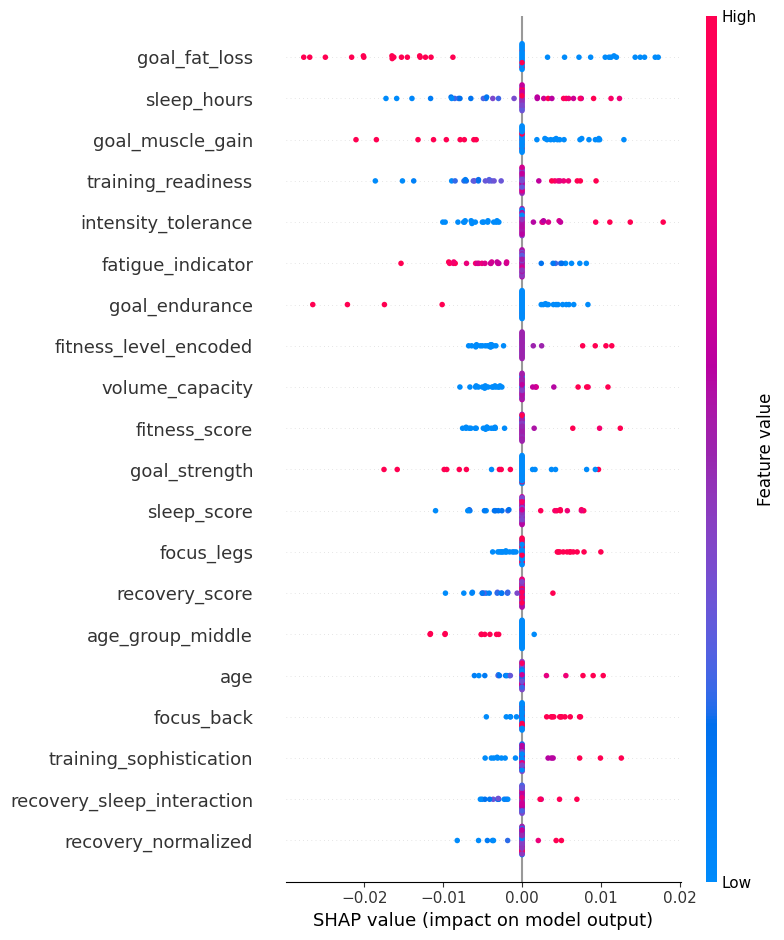

📊 SHAP summary saved!


In [15]:
# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, test_samples, feature_names=data['feature_names'], show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 SHAP summary saved!")

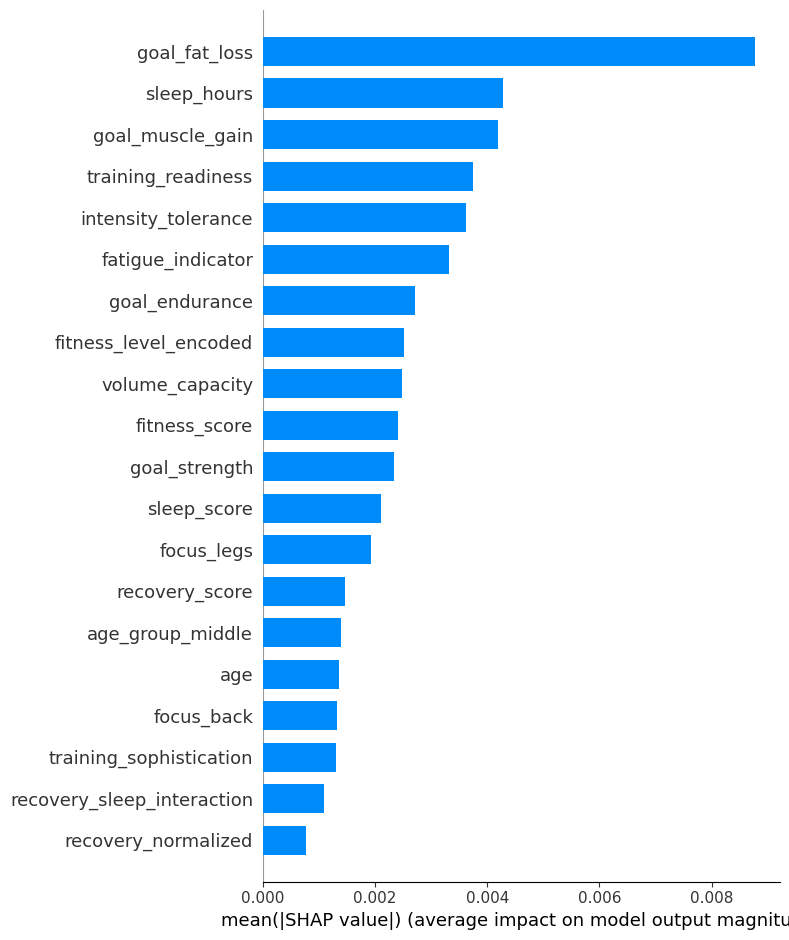

📊 Feature importance saved!


In [16]:
# Feature Importance Bar Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, test_samples, feature_names=data['feature_names'], plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Feature importance saved!")

## 1️⃣1️⃣ Export Model Artifacts

In [19]:
import pickle
import joblib
# Save model (using .keras format as recommended)
model.save('enhanced_workout_model.keras')
print("✅ Model saved: enhanced_workout_model.keras")
# Also save as .h5 for backward compatibility
model.save('enhanced_workout_model.h5')
print("✅ Model saved: enhanced_workout_model.h5")
# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(data['scaler'], f)
print("✅ Scaler saved: feature_scaler.pkl")
# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(data['label_encoder'], f)
print("✅ Label encoder saved: label_encoder.pkl")
# Save SHAP background data (instead of explainer - we'll recreate it)
# The explainer can be recreated using: shap.KernelExplainer(model_fn, background_data)
np.save('shap_background_data.npy', background)
print("✅ SHAP background data saved: shap_background_data.npy")
# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(data['feature_names'], f)
print("✅ Feature names saved: feature_names.json")
# Save metadata
metadata = {
    'training_date': datetime.now().isoformat(),
    'num_samples': len(raw_data),
    'num_features': len(feature_cols),
    'model_architecture': 'Multi-output Neural Network',
    'outputs': ['sets', 'reps', 'intensity', 'rest_seconds', 'workout_type'],
    'novelty_features': ['SHAP Explainability', 'Multi-Task Learning', 'Recovery-Aware Training'],
    'shap_note': 'Recreate explainer with: shap.KernelExplainer(model_fn, np.load("shap_background_data.npy"))'
}
with open('training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved: training_metadata.json")
print("\n📦 ALL ARTIFACTS EXPORTED!")

✅ Model saved: enhanced_workout_model.keras
✅ Model saved: enhanced_workout_model.h5
✅ Scaler saved: feature_scaler.pkl
✅ Label encoder saved: label_encoder.pkl
✅ SHAP background data saved: shap_background_data.npy
✅ Feature names saved: feature_names.json
✅ Metadata saved: training_metadata.json

📦 ALL ARTIFACTS EXPORTED!


In [20]:
from google.colab import files
print("📥 Downloading model artifacts...")
files.download('enhanced_workout_model.keras')
files.download('enhanced_workout_model.h5')
files.download('feature_scaler.pkl')
files.download('label_encoder.pkl')
files.download('shap_background_data.npy')
files.download('feature_names.json')
files.download('training_metadata.json')
files.download('training_history.png')
files.download('shap_summary.png')
files.download('shap_importance.png')
print("\n🎉 All files downloaded!")

📥 Downloading model artifacts...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 All files downloaded!


## 1️⃣2️⃣ Inference Demo

In [21]:
# Demo prediction
print("🔮 Running inference demo...")

# Sample user
demo_features = np.zeros((1, len(feature_cols)))
demo_features[0, 0] = 28   # age
demo_features[0, 1] = 1    # male
demo_features[0, 2] = 78   # weight
demo_features[0, 3] = 180  # height
demo_features[0, 4] = 24.1 # bmi
demo_features[0, 5] = 1    # intermediate
demo_features[0, 8] = 1    # goal_muscle_gain
demo_features[0, 12] = 1   # full_gym
demo_features[0, 30] = 82  # recovery_score
demo_features[0, 32] = 65  # hrv
demo_features[0, 34] = 7.5 # sleep
demo_features[0, 39] = 0.78 # training_readiness

# Scale
demo_scaled = data['scaler'].transform(demo_features)

# Predict
preds = model.predict(demo_scaled, verbose=0)

print("\n📋 DEMO PREDICTION:")
print(f"   Sets: {int(np.clip(round(preds[0][0][0]), 2, 6))}")
print(f"   Reps: {int(np.clip(round(preds[1][0][0]), 4, 20))}")
print(f"   Intensity: {np.clip(preds[2][0][0], 0.5, 1.0):.0%}")
print(f"   Rest: {int(np.clip(round(preds[3][0][0]), 30, 300))}s")
print(f"   Workout Type: {data['label_encoder'].classes_[np.argmax(preds[4][0])]}")

🔮 Running inference demo...

📋 DEMO PREDICTION:
   Sets: 3
   Reps: 12
   Intensity: 82%
   Rest: 63s
   Workout Type: HIIT


---
# 🎉 Pipeline Complete!

**Summary:**
- ✅ 3000+ samples generated
- ✅ 45 features engineered
- ✅ Multi-output model trained (5 predictions)
- ✅ SHAP explainability added
- ✅ All artifacts exported

**Next Steps:**
1. Download all `.h5`, `.pkl`, and `.json` files
2. Copy to `fitness-backend/app/models/`
3. Restart FastAPI server
4. Test `/predict/workout/explain` endpoint